Data:
- scaled to range [0:1] features: sent_ken, TOKEN, 
- no feature 'idx'
- binary features replaces from 0/1 to 0/.067 according to mean value of rest of the features
- test ratio  is 10%
- tfidf is with 100 stop_words and 100 stop_lemmas
- XXX XXXX replaced with XXX
- removed XXXword sticky occurances 
- short sentences merged into long (3+ words)

In [176]:
import pandas as pd
import os,sys, imp
sys.path.append('./src/')
import doc_utils_clean as doc_utils
import feature_utils, common_utils
import defines
import numpy as np
from sklearn_crfsuite import scorers, CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut,GroupKFold

from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import random
import model_utils
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import Counter
import scipy
import nltk

import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.pipeline import Pipeline


In [103]:
dir_name="scaled_minmax"

In [104]:
db_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name)
db_path

'/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/scaled_minmax'

### Get df with features of all docs

In [105]:
merged_db = common_utils.concat_dbs(dir_name,"merged_db")
merged_db.head()

,doc_idx,merged_idx,is_question,is_nar,par_idx_in_doc,sent_len,is_client,sent_idx_in_par,sent_pos_in_par,sent_pos_in_doc,...,f_per_2,f_per_3,f_per_A,f_tense_BEINONI,f_tense_FUTURE,f_tense_IMPERATIVE,f_tense_PAST,POSTAG_NEG,POSTAG_yyCM,POSTAG_TTL
0,1,0,0.000000,0.000000,0.000000,47.000000,0,0,1.000000,0.001724,...,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,1,1,0.000000,0.000000,1.000000,2.000000,1,0,1.000000,0.003448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
2,1,2,1.000000,0.000000,2.000000,16.000000,0,0,1.000000,0.005172,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
3,1,3,0.000000,0.000000,3.000000,8.000000,1,0,1.000000,0.006897,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
4,1,4,0.000000,0.000000,4.000000,19.000000,0,0,1.000000,0.008621,...,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN


In [106]:
for col in merged_db.columns:
    if 'is' in col or 'idx' in col:
        merged_db[col] = merged_db[col].astype(int)

### Fill NaN values with 0 (for POS counters)

In [107]:
merged_db.fillna(value=0,inplace=True)

In [108]:
merged_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35093 entries, 0 to 35092
Data columns (total 66 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   doc_idx             35093 non-null  int64  
 1   merged_idx          35093 non-null  int64  
 2   is_question         35093 non-null  int64  
 3   is_nar              35093 non-null  int64  
 4   par_idx_in_doc      35093 non-null  int64  
 5   sent_len            35093 non-null  float64
 6   is_client           35093 non-null  int64  
 7   sent_idx_in_par     35093 non-null  int64  
 8   sent_pos_in_par     35093 non-null  float64
 9   sent_pos_in_doc     35093 non-null  float64
 10  TOKEN               35093 non-null  int64  
 11  POSTAG_ADVERB       35093 non-null  float64
 12  POSTAG_AT           35093 non-null  float64
 13  POSTAG_BN           35093 non-null  float64
 14  POSTAG_BNT          35093 non-null  float64
 15  POSTAG_CC           35093 non-null  float64
 16  POST

In [109]:
merged_db.describe()

,doc_idx,merged_idx,is_question,is_nar,par_idx_in_doc,sent_len,is_client,sent_idx_in_par,sent_pos_in_par,sent_pos_in_doc,...,f_per_2,f_per_3,f_per_A,f_tense_BEINONI,f_tense_FUTURE,f_tense_IMPERATIVE,f_tense_PAST,POSTAG_NEG,POSTAG_yyCM,POSTAG_TTL
count,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,...,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000
mean,41.052974,261.040948,0.135668,0.269341,110.982418,51.124156,0.626051,3.109139,0.712550,0.501140,...,0.039993,0.165759,0.092159,0.004566,0.016163,0.002460,0.048888,0.000039,0.000057,0.000007
std,24.672703,188.127025,0.342441,0.443624,94.884523,70.901944,0.483857,6.052823,0.301557,0.288679,...,0.093175,0.173047,0.119239,0.030439,0.055510,0.029495,0.096168,0.002228,0.007549,0.001335
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.012821,0.001032,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,109.000000,0.000000,0.000000,42.000000,18.000000,0.000000,0.000000,0.500000,0.251177,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,227.000000,0.000000,0.000000,82.000000,32.000000,1.000000,1.000000,0.794872,0.501114,...,0.000000,0.142857,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,64.000000,379.000000,0.000000,1.000000,153.000000,59.000000,1.000000,3.000000,1.000000,0.751174,...,0.000000,0.250000,0.166667,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000
max,80.000000,968.000000,1.000000,1.000000,527.000000,1661.000000,1.000000,77.000000,1.000000,1.000000,...,1.000000,2.000000,2.000000,0.666667,1.000000,1.000000,1.333333,0.200000,1.000000,0.250000


### Scale sent len and TOKEN

In [128]:
from sklearn.preprocessing import StandardScaler
scaler = MaxAbsScaler()
scaler.fit(merged_db[['sent_len','TOKEN']])
scaled_merge=pd.DataFrame(scaler.transform(merged_db[['sent_len','TOKEN']]),columns =['sent_len','TOKEN'],index=merged_db.index)

In [129]:
scaled_merge

,sent_len,TOKEN
0,0.028296,0.049505
1,0.001204,0.004950
2,0.009633,0.009901
3,0.004816,0.009901
4,0.011439,0.024752
...,...,...
35088,0.012643,0.024752
35089,0.016255,0.029703
35090,0.013847,0.029703
35091,0.011439,0.014851


In [130]:
merged_db['sent_len']=scaled_merge['sent_len']
merged_db['TOKEN']=scaled_merge['TOKEN']

### Scale binary features

In [131]:
binary_columns = []
idx_columns = []
for col in merged_db.columns:
    if 'is' in col:
        binary_columns.append(col)
    if 'idx' in col:
        idx_columns.append(col)
    

In [132]:
non_pos_columns = binary_columns + idx_columns
non_pos_columns

['is_question',
 'is_nar',
 'is_client',
 'doc_idx',
 'merged_idx',
 'par_idx_in_doc',
 'sent_idx_in_par']

In [133]:
print(non_pos_columns)

['is_question', 'is_nar', 'is_client', 'doc_idx', 'merged_idx', 'par_idx_in_doc', 'sent_idx_in_par']


In [134]:
stat=merged_db[merged_db.columns[~merged_db.columns.isin(non_pos_columns)]].describe()

In [135]:
stat

,sent_len,sent_pos_in_par,sent_pos_in_doc,TOKEN,POSTAG_ADVERB,POSTAG_AT,POSTAG_BN,POSTAG_BNT,POSTAG_CC,POSTAG_CD,...,f_per_2,f_per_3,f_per_A,f_tense_BEINONI,f_tense_FUTURE,f_tense_IMPERATIVE,f_tense_PAST,POSTAG_NEG,POSTAG_yyCM,POSTAG_TTL
count,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,...,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000,35093.000000
mean,0.030779,0.712550,0.501140,0.047151,0.004201,0.029568,0.082364,0.000878,0.050571,0.009324,...,0.039993,0.165759,0.092159,0.004566,0.016163,0.002460,0.048888,0.000039,0.000057,0.000007
std,0.042686,0.301557,0.288679,0.052033,0.047354,0.066290,0.115210,0.010629,0.092991,0.045019,...,0.093175,0.173047,0.119239,0.030439,0.055510,0.029495,0.096168,0.002228,0.007549,0.001335
min,0.000602,0.012821,0.001032,0.004950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010837,0.500000,0.251177,0.019802,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.019266,0.794872,0.501114,0.029703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.142857,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.035521,1.000000,0.751174,0.059406,0.000000,0.000000,0.142857,0.000000,0.083333,0.000000,...,0.000000,0.250000,0.166667,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.500000,1.000000,1.000000,...,1.000000,2.000000,2.000000,0.666667,1.000000,1.000000,1.333333,0.200000,1.000000,0.250000


In [136]:
stat_mean=stat.mean(axis=1)
stat_mean

count   35093.000000
mean        0.079064
std         0.090651
min         0.000329
25%         0.027311
50%         0.054319
75%         0.104419
max         1.374859
dtype: float64

In [137]:
binary_lablel=np.array([stat_mean['mean'],stat_mean['50%']]).mean()
binary_lablel

0.066691673603957

In [142]:
merged_db.replace({'is_question': {1: binary_lablel},
                    'is_nar': {1:binary_lablel},
                     'is_client': {1:binary_lablel}})


,doc_idx,merged_idx,is_question,is_nar,par_idx_in_doc,sent_len,is_client,sent_idx_in_par,sent_pos_in_par,sent_pos_in_doc,...,f_per_2,f_per_3,f_per_A,f_tense_BEINONI,f_tense_FUTURE,f_tense_IMPERATIVE,f_tense_PAST,POSTAG_NEG,POSTAG_yyCM,POSTAG_TTL
0,1,0,0.000000,0.000000,0,0.028296,0.000000,0,1.000000,0.001724,...,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1,0.000000,0.000000,1,0.001204,0.066692,0,1.000000,0.003448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,2,0.066692,0.000000,2,0.009633,0.000000,0,1.000000,0.005172,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,3,0.000000,0.000000,3,0.004816,0.066692,0,1.000000,0.006897,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,4,0.000000,0.000000,4,0.011439,0.000000,0,1.000000,0.008621,...,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35088,80,486,0.000000,0.000000,222,0.012643,0.066692,3,0.666667,0.991853,...,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35089,80,487,0.000000,0.000000,222,0.016255,0.066692,4,0.833333,0.993890,...,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35090,80,488,0.000000,0.000000,222,0.013847,0.066692,5,1.000000,0.995927,...,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35091,80,489,0.066692,0.000000,223,0.011439,0.000000,0,1.000000,0.997963,...,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [139]:
db_path

'/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/scaled_minmax'

In [140]:
scaled_name="scaled.binary{:.3f}_merged".format(binary_lablel,lstrip='0')
scaled_name

'scaled.binary0.067_merged'

In [144]:
for doc in merged_db['doc_idx'].unique():
    df_to_write = merged_db[merged_db['doc_idx']==doc].iloc[:,2:]
    df_to_write.to_csv(os.path.join(db_path,'{:02d}_{}.csv'.format(doc,scaled_name)), index=False)

In [145]:
imp.reload(feature_utils)
scaled_docs_map = feature_utils.pack_all_doc_sentences_to_map(dir_name,
                                                              per_par=True,
                                                              limit=0,
                                                              doc_as_sequence=1,
                                                              sent_lemma_db_list=[],
                                                              tf_types = ['word','char_wb','lemma'],
                                                              merged_str = scaled_name
                                                             )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
14918 items packed for 80 docs


In [147]:
imp.reload(common_utils)
common_utils.get_random_sample(scaled_docs_map)

[{'is_question': 0,
  'sent_len': 0.0258880192655027,
  'is_client': 0,
  'sent_pos_in_par': 1.0,
  'sent_pos_in_doc': 0.2622377622377622,
  'TOKEN': 0.0445544554455445,
  'POSTAG_AT': 0.2222222222222222,
  'POSTAG_BN': 0.1111111111111111,
  'POSTAG_JJ': 0.1111111111111111,
  'POSTAG_MD': 0.1111111111111111,
  'POSTAG_NNP': 0.1111111111111111,
  'POSTAG_PREPOSITION': 0.1111111111111111,
  'POSTAG_PRP': 0.1111111111111111,
  'POSTAG_QW': 0.2222222222222222,
  'POSTAG_RB': 0.1111111111111111,
  'POSTAG_REL': 0.1111111111111111,
  'f_gen_F': 0.2222222222222222,
  'f_gen_M': 0.3333333333333333,
  'f_num_S': 0.5555555555555556,
  'f_per_3': 0.1111111111111111,
  'f_per_A': 0.2222222222222222,
  '-1:is_question': 0,
  '-1:sent_len': 0.0012040939193257,
  '-1:is_client': 1,
  '-1:sent_pos_in_par': 1.0,
  '-1:sent_pos_in_doc': 0.2604895104895104,
  '-1:TOKEN': 0.0049504950495049,
  '-1:POSTAG_RB': 1.0,
  '+1:is_question': 0,
  '+1:sent_len': 0.0288982540638169,
  '+1:is_client': 1,
  '+1:sent_

In [148]:
import json
imp.reload(common_utils)
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"min.max.sacled_docs_map.json")

with open(json_path, 'w') as fp:
    json.dump(scaled_docs_map, fp)


In [149]:
imp.reload(feature_utils)
imp.reload(model_utils)
seq_len=3
step=3
per_par=True
feature_utils.reshape_docs_map_to_seq(scaled_docs_map,per_par,seq_len,step)

[58] 384 -> 128 [67] 407 -> 136 [72] 420 -> 140 [53] 149 -> 50 [46] 200 -> 67 [79] 172 -> 58 [11] 121 -> 41 [4] 132 -> 44 [25] 122 -> 41 [30] 82 -> 28 [9] 276 -> 92 [23] 74 -> 25 [36] 87 -> 29 [17] 322 -> 108 [2] 156 -> 52 [80] 223 -> 75 [28] 167 -> 56 [55] 249 -> 83 [40] 148 -> 50 [61] 433 -> 145 [74] 95 -> 32 [78] 122 -> 41 [52] 275 -> 92 [47] 160 -> 54 [66] 366 -> 122 [73] 85 -> 29 [59] 370 -> 124 [24] 158 -> 53 [31] 79 -> 27 [10] 123 -> 41 [5] 65 -> 22 [29] 105 -> 35 [16] 102 -> 34 [3] 113 -> 38 [22] 89 -> 30 [37] 99 -> 33 [8] 82 -> 28 [60] 245 -> 82 [75] 68 -> 23 [54] 243 -> 81 [41] 137 -> 46 [32] 73 -> 25 [27] 67 -> 23 [18] 62 -> 21 [39] 111 -> 37 [6] 420 -> 140 [13] 90 -> 30 [44] 199 -> 67 [51] 208 -> 70 [70] 183 -> 61 [65] 335 -> 112 [76] 132 -> 44 [63] 338 -> 113 [49] 206 -> 69 [68] 439 -> 147 [42] 136 -> 46 [57] 271 -> 91 [15] 121 -> 41 [34] 49 -> 17 [21] 108 -> 36 [7] 248 -> 83 [12] 150 -> 50 [38] 90 -> 30 [19] 265 -> 89 [33] 91 -> 31 [26] 114 -> 38 [71] 156 -> 52 [64] 347 -

In [152]:
X=np.arange(0,81)
X

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

In [165]:
test_percent=0.2
n_groups=int(test_percent*len(scaled_docs_map.keys()))

In [168]:
imp.reload(model_utils)
myGrFold=model_utils.MyLeavePGroupsOut(n_groups=n_groups,n_splits=3)

In [169]:
for tr,ts in myGrFold.split(X=X,groups=X):
    print(tr,ts)

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[15 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16]
[15 16 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17]


In [183]:
imp.reload(model_utils)
test_percent = 0.1
seed=42
n_test_groups=int(len(scaled_docs_map.keys())*test_percent)
cross_test_cv=model_utils.MyLeavePGroupsOut(n_groups=n_groups,n_splits=1)
all_groups=list(scaled_docs_map.keys())
for train_indices,test_indices in cross_test_cv.split(X=all_groups,groups=all_groups):
    print(train_indices,test_indices)

[ 0  1  2  3  4  5  8  9 11 12 13 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 31 34 35 37 38 39 40 41 42 43 44 47 48 49 50 51 52 53 54 55 56 58 59
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77] [ 6  7 10 14 29 30 32 33 36 45 46 57 60 61 78 79]


In [190]:
train_indices=np.array(train_indices)+1
test_indices=np.array(test_indices)+1

In [191]:
print(train_indices,test_indices)

[ 1  2  3  4  5  6  9 10 12 13 14 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 32 35 36 38 39 40 41 42 43 44 45 48 49 50 51 52 53 54 55 56 57 59 60
 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78] [ 7  8 11 15 30 31 33 34 37 46 47 58 61 62 79 80]


In [194]:
imp.reload(model_utils)
X_train,y_train,groups_train =  model_utils.get_X_y_by_doc_indices(scaled_docs_map,train_indices,seq_len,step)

In [196]:
len(groups_train),len(y_train)

(4060, 4060)

In [199]:
X_test,y_test,groups_test =  model_utils.get_X_y_by_doc_indices(scaled_docs_map,test_indices,seq_len,step)
len(groups_test),len(y_test)

(939, 939)

In [201]:
%%time
# define fixed parameters and parameters to search
n_groups=int(test_percent*len(train_indices))
my_cv=model_utils.MyLeavePGroupsOut(n_groups=n_groups,n_splits=3)
crf_scaled = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs_scaled = RandomizedSearchCV(crf_scaled, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs_scaled.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
102 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 4min 5s, sys: 48.5 s, total: 4min 53s
Wall time: 5min 11s


RandomizedSearchCV(cv=MyLeavePGroupsOut(n_groups=6, n_splits=3),
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b2a569f3460>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b2a569d7880>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [202]:
# crf = rs.best_estimator_
print('best params:', rs_scaled.best_params_)
print('best CV score:', rs_scaled.best_score_)
print('model size: {:0.2f}M'.format(rs_scaled.best_estimator_.size_ / 1000000))

best params: {'algorithm': 'lbfgs', 'c1': 0.3279365166482093, 'c2': 0.031618229302948546, 'min_freq': 9}
best CV score: 0.8063390389473121
model size: 0.36M


In [203]:
import json
imp.reload(common_utils)
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"best_params_min.max.scaled.json")

best_params_pyth = common_utils.convert_to_python_types(rs_scaled.best_params_)
with open(json_path, 'w') as fp:
    json.dump(best_params_pyth, fp)



              precision    recall  f1-score   support

      is_nar       0.60      0.55      0.58      1604
     not_nar       0.85      0.88      0.87      4791

    accuracy                           0.80      6395
   macro avg       0.73      0.72      0.72      6395
weighted avg       0.79      0.80      0.79      6395



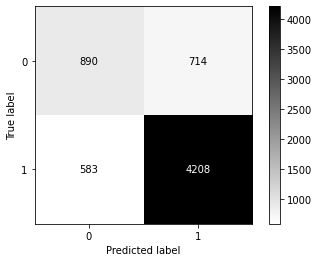

In [204]:
best_crf = rs_scaled.best_estimator_
y_pred  =  best_crf.predict(X_test)
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),crf_scaled.classes_)

### Look at the features


In [207]:
dir_name

'scaled_minmax'

In [205]:
imp.reload(model_utils)
all_features_cv = model_utils.get_features_df(dir_name,Counter(best_crf.state_features_).most_common())

In [211]:
all_features_cv.iloc[:30]

,weight,label,attr,string
0,4.558085,not_nar,tfidf_lemma_6684,עוצמה
1,4.004521,not_nar,tfidf_lemma_1042,בחיר
2,3.839053,not_nar,tfidf_word_20934,שאמרת
3,3.711084,not_nar,tfidf_word_4430,הגעת
4,3.690193,not_nar,tfidf_word_15980,מחפש
5,3.660786,not_nar,tfidf_word_9178,ולהגיד
6,3.608555,not_nar,tfidf_char_wb_18238,יחו
7,3.365585,not_nar,tfidf_word_12816,לדחות
8,3.246583,not_nar,tfidf_char_wb_19139,יקר
9,3.043858,not_nar,tfidf_lemma_1192,במקום


In [213]:
all_features_cv[all_features_cv['label']=='is_nar'][:30]

,weight,label,attr,string
13,2.861167,is_nar,tfidf_char_wb_2619,התק
14,2.821573,is_nar,tfidf_lemma_452,איכל
15,2.805880,is_nar,tfidf_word_4934,החברה
17,2.744949,is_nar,tfidf_lemma_7626,קיבע
20,2.672952,is_nar,tfidf_lemma_5062,מחלקה
21,2.583296,is_nar,tfidf_word_884,אמרה
25,2.479969,is_nar,tfidf_word_20799,רצית
30,2.395757,is_nar,tfidf_lemma_8304,שילח
34,2.247928,is_nar,tfidf_char_wb_4497,לכ
42,2.097098,is_nar,tfidf_lemma_6130,נפרד


In [214]:
all_features_cv[all_features_cv['attr'].str.contains("POS")][:30]

,weight,label,attr,string
70,1.715849,not_nar,-2:POSTAG_CDT,
256,0.764280,not_nar,+1:POSTAG_CDT,
359,0.513857,not_nar,POSTAG_CDT,
378,0.465116,not_nar,+2:POSTAG_CDT,
419,0.401100,not_nar,-1:POSTAG_CDT,
428,0.390113,is_nar,-1:POSTAG_INTJ,
540,0.247860,not_nar,-2:POSTAG_EX,
579,0.214725,not_nar,+1:POSTAG_EX,
599,0.206286,not_nar,+1:POSTAG_CD,
660,0.168267,is_nar,-2:POSTAG_INTJ,


### Save all features db

In [208]:
f_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"crf_features.csv")
all_features_cv.to_csv(f_path,index=False)

## Feature selection based on weight

<AxesSubplot:ylabel='Frequency'>

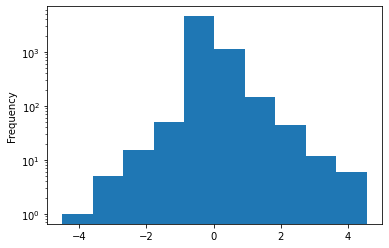

In [209]:
all_features_cv['weight'].plot(kind='hist',logy=True)

In [210]:
q = all_features_cv['weight'].quantile(q=[0.1, 0.9])
q

0.100000   -0.078105
0.900000    0.206263
Name: weight, dtype: float64

In [339]:
q.iloc[0],q.iloc[1]

(-0.022233799999999998, 0.096775)